In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import os
import keras
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator


In [46]:
train_dir = os.path.dirname('/content/drive/MyDrive/intel-image-classification/seg_train/seg_train/')
test_dir = os.path.dirname('/content/drive/MyDrive/intel-image-classification/seg_test/seg_test/')
pred_dir = os.path.dirname('/content/drive/MyDrive/intel-image-classification/seg_pred/')

In [47]:
## Generators ##
 
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

valid_datagen = ImageDataGenerator(
    rescale = 1./255,
)

pred_datagen = ImageDataGenerator(
    rescale = 1./255,
)

In [48]:
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    class_mode='categorical',
    batch_size = 64,
    shuffle=True,
    target_size = (224, 224)
)

test_dataset = valid_datagen.flow_from_directory(
    test_dir,
    class_mode='categorical',
    batch_size = 64,
    shuffle=False,
    target_size = (224, 224)
)

pred_dataset = pred_datagen.flow_from_directory(
    pred_dir,
    class_mode='categorical',
    batch_size = 64,
    shuffle=False,
    target_size = (224, 224)
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


In [50]:
# load ResNet50 model without classification layers
model = ResNet50(include_top=False, input_shape=(224, 224, 3))

In [51]:
# add new classification layers
model = ResNet50(include_top=False, input_shape=(224, 224, 3))
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(6, activation='softmax')(x)

In [52]:
# define the new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [53]:
from keras.utils.vis_utils import plot_model

In [55]:
from keras.optimizers import SGD
import numpy
sgd = SGD(lr=0.001, decay=1e-7, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [56]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.00001)

cb_checkpointer = ModelCheckpoint(filepath = 'vgg16_checkpoint.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')

In [57]:
resnet50_clf =  model.fit(train_dataset, validation_data = test_dataset, epochs = 10, callbacks=[cb_checkpointer, learning_rate_reduction])

Epoch 1/10
220/220 [==============================] - 219s 978ms/step - loss: 0.9044 - accuracy: 0.6574 - val_loss: 2.6625 - val_accuracy: 0.1660
Epoch 2/10
220/220 [==============================] - 217s 985ms/step - loss: 0.3145 - accuracy: 0.8917 - val_loss: 2.4877 - val_accuracy: 0.2223
Epoch 3/10
220/220 [==============================] - 217s 983ms/step - loss: 0.2630 - accuracy: 0.9048 - val_loss: 0.7763 - val_accuracy: 0.7093
Epoch 4/10
220/220 [==============================] - 217s 986ms/step - loss: 0.2287 - accuracy: 0.9190 - val_loss: 0.3110 - val_accuracy: 0.8860
Epoch 5/10
220/220 [==============================] - 217s 986ms/step - loss: 0.2022 - accuracy: 0.9290 - val_loss: 0.2281 - val_accuracy: 0.9120
Epoch 6/10
220/220 [==============================] - 218s 990ms/step - loss: 0.1935 - accuracy: 0.9273 - val_loss: 0.2320 - val_accuracy: 0.9130
Epoch 7/10
220/220 [==============================] - 216s 981ms/step - loss: 0.1787 - accuracy: 0.9343 - val_loss: 0.1972 -

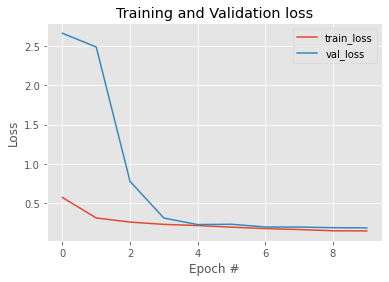

In [58]:
import matplotlib.pyplot as plt
import numpy as np
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, resnet50_clf.history['loss'], label='train_loss')
plt.plot(N, resnet50_clf.history['val_loss'], label='val_loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.show()

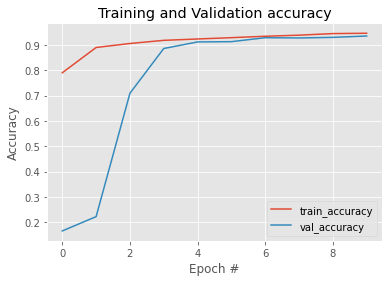

In [59]:

N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, resnet50_clf.history['accuracy'], label='train_accuracy')
plt.plot(N, resnet50_clf.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [61]:
score = model.evaluate(pred_dataset, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

115/115 [==============================] - 24s 210ms/step - loss: 0.4407 - accuracy: 0.8988
Test Loss =  0.4406679570674896
Test Accuracy =  0.8987810015678406


In [62]:
##CONFUSION MATRIX
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(pred_dataset)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(pred_dataset.classes, y_pred))
target_names = ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street']

Confusion Matrix
[[1047    5    4    1    8   79]
 [   4 1154    2    2    2    2]
 [   3    6 1079  188   51    3]
 [   5    8   95 1113   73    3]
 [  11    5   24   54 1025    9]
 [  66   12    2    2   10 1144]]


In [63]:
print('Classification Report')
print(classification_report(pred_dataset.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   Buildings       0.92      0.92      0.92      1144
      Forest       0.97      0.99      0.98      1166
     Glacier       0.89      0.81      0.85      1330
    Mountain       0.82      0.86      0.84      1297
         Sea       0.88      0.91      0.89      1128
      Street       0.92      0.93      0.92      1236

    accuracy                           0.90      7301
   macro avg       0.90      0.90      0.90      7301
weighted avg       0.90      0.90      0.90      7301



In [65]:
model.save_weights('/content/drive/MyDrive/CV_A3/resnet50_transfer_learning_trained_ver1_wts.h5')